### Data Reduction Steps

- **Remove unnecessary columns**  
  - Drop columns like `customerID` that do not provide predictive value.

- **Reduce redundancy**  
  - Remove low-variance and highly correlated features to simplify the dataset.

- **Create meaningful features**  
  - Example: `AvgMonthlySpend` calculated from `TotalCharges` and `tenure`.

- **Reduce dataset size while preserving churn distribution**  
  - Apply stratified sampling (80% of rows) to maintain class balance.

- **Save the final reduced dataset**  
  - Export the processed dataset for modeling and analysis.


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

In [116]:
df = pd.read_csv("03.transformed_telco_data.csv")
print("transformed data:", df.shape)
df.head()

transformed data: (55280, 41)


,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Contract_One year,Contract_Two year,TenureGroup_Medium,TenureGroup_Long,MonthlyChargeGroup_Medium,MonthlyChargeGroup_High,TotalChargeGroup_Medium,TotalChargeGroup_High,AvgMonthlyChargeGroup_Medium,AvgMonthlyChargeGroup_High
0,CUST00001,0.0,0.0,1.0,-1.244740,Yes,Yes,No,No,No,...,False,False,False,False,False,True,False,False,True,False
1,CUST00002,1.0,1.0,0.0,-1.244740,Yes,Yes,No,No,No,...,True,False,False,False,False,False,False,False,True,False
2,CUST00003,0.0,0.0,0.0,1.104164,Yes,Yes,No,Yes,No,...,False,False,False,True,True,False,False,True,False,True
3,CUST00005,1.0,1.0,1.0,-0.476370,Yes,Unknown,Yes,No,Yes,...,False,True,False,False,False,False,False,False,False,False
4,CUST00006,0.0,1.0,0.0,-0.064392,Yes,No,No,No,Unknown,...,True,False,True,False,True,False,True,False,False,False


In [117]:

selector = VarianceThreshold(threshold=0.01)  
selector.fit(df.select_dtypes(include=[np.number]))

low_variance_features = df.select_dtypes(include=[np.number]).columns[~selector.get_support()]
print("Low-variance features dropped:", list(low_variance_features))

df = df.drop(columns=low_variance_features)
print("Shape after variance filtering:", df.shape)


Low-variance features dropped: []
Shape after variance filtering: (55280, 41)


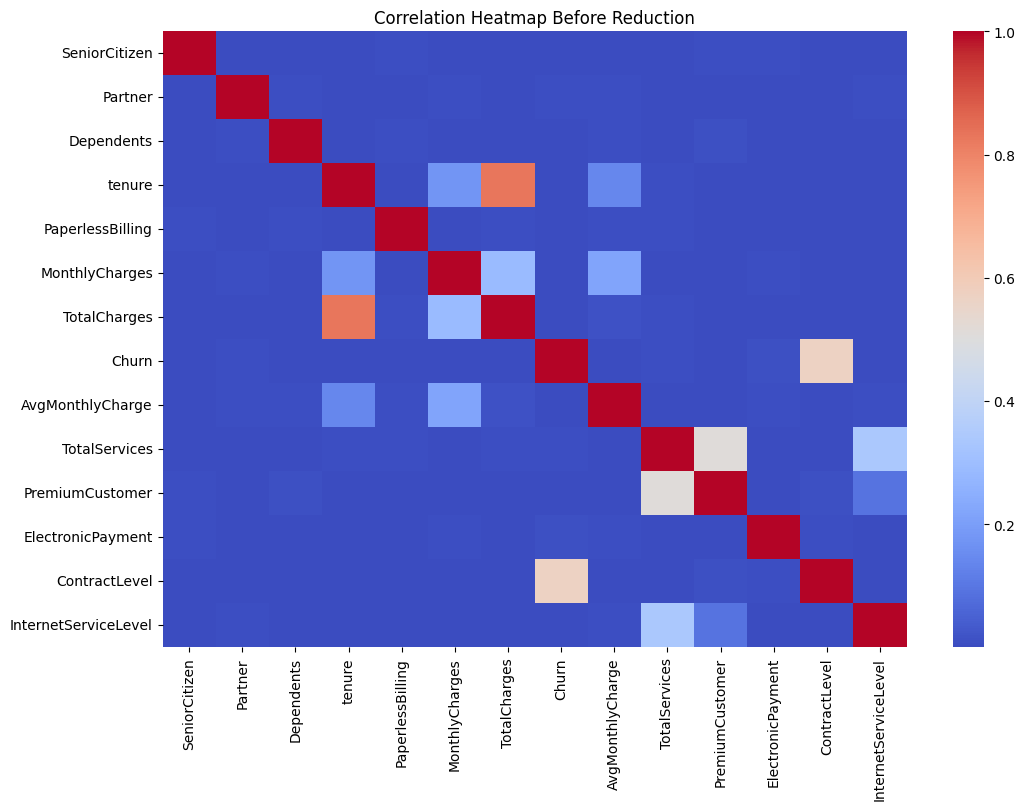

Highly correlated features dropped: []
Shape after correlation filtering: (55280, 41)


In [118]:
#  Drop highly correlated features 
corr_matrix = df.select_dtypes(include=[np.number]).corr().abs()


plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap Before Reduction")
plt.show()


upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print("Highly correlated features dropped:", to_drop)

df = df.drop(columns=to_drop)
print("Shape after correlation filtering:", df.shape)


Correlation matrix (before dropping TotalCharges):
                   tenure  MonthlyCharges  TotalCharges  AvgMonthlySpend
tenure           1.000000       -0.174179      0.829080         0.139995
MonthlyCharges  -0.174179        1.000000      0.288667        -0.215875
TotalCharges     0.829080        0.288667      1.000000        -0.015328
AvgMonthlySpend  0.139995       -0.215875     -0.015328         1.000000


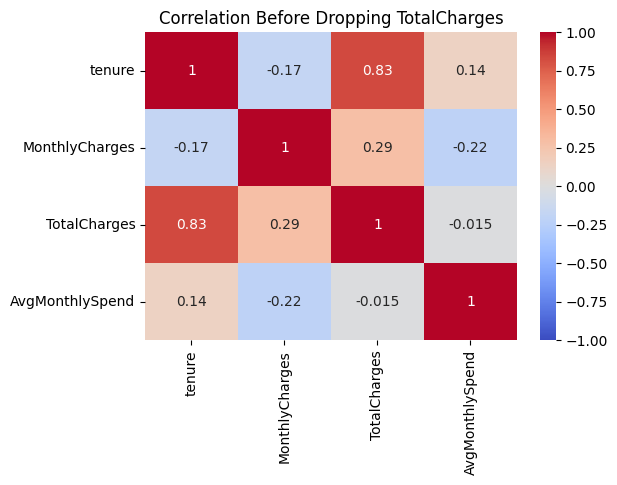


Correlation matrix (after dropping TotalCharges):
                   tenure  MonthlyCharges  AvgMonthlySpend
tenure           1.000000       -0.174179         0.139995
MonthlyCharges  -0.174179        1.000000        -0.215875
AvgMonthlySpend  0.139995       -0.215875         1.000000


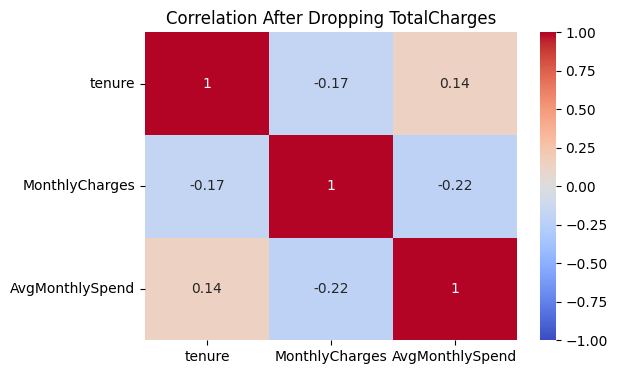


Preview after dropping TotalCharges:
     tenure  MonthlyCharges  AvgMonthlySpend
0 -1.244740        1.000000        -0.030587
1 -1.244740        0.000000        -0.000000
2  1.104164        0.391770         0.690391
3 -0.476370        0.000000        -0.239639
4 -0.064392        0.261407        -4.169915


In [119]:
# create new feature average monthly spend and remove total charge 
df["AvgMonthlySpend"] = df["TotalCharges"] / df["tenure"].replace(0, np.nan)


corr_before = df[["tenure", "MonthlyCharges", "TotalCharges", "AvgMonthlySpend"]].corr()
print("Correlation matrix (before dropping TotalCharges):")
print(corr_before)

plt.figure(figsize=(6,4))
sns.heatmap(corr_before, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Before Dropping TotalCharges")
plt.show()


df = df.drop(columns=["TotalCharges"])


corr_after = df[["tenure", "MonthlyCharges", "AvgMonthlySpend"]].corr()
print("\nCorrelation matrix (after dropping TotalCharges):")
print(corr_after)

plt.figure(figsize=(6,4))
sns.heatmap(corr_after, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation After Dropping TotalCharges")
plt.show()


print("\nPreview after dropping TotalCharges:")
print(df[["tenure", "MonthlyCharges", "AvgMonthlySpend"]].head())


**Reason:**  
`AvgMonthlySpend` is better than `TotalCharges` because it shows the customer’s **average spending per month**, independent of **tenure**, while `TotalCharges` is **cumulative** and highly correlated with tenure, which can be misleading for **new or short-tenure customers**.


In [120]:

# Remove customerID 
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

In [121]:

#  Numerosity reduction: stratified sampling (80% of rows)
df_reduced = (
    df.groupby('Churn', group_keys=False)
      .sample(frac=0.8, random_state=42)
      .reset_index(drop=True)
)


**Why:** The original dataset has 70,000 rows. We apply stratified numerosity reduction to **reduce the dataset size** for faster processing and modeling, while **preserving the proportion of churn classes** to avoid introducing bias.


In [122]:
df_reduced.to_csv("04.reduced_telco_data.csv", index=False)
print("Reduced dataset saved as 04.reduced_telco_data.csv")

Reduced dataset saved as 04.reduced_telco_data.csv
